# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV,  RepeatedStratifiedKFold

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

In [9]:
# Imbalance in booking complete and uncomplete
booking_counts = df["booking_complete"].value_counts()

print("Count of Booking 0:", booking_counts[0])
print("Count of Booking 1:", booking_counts[1])

Count of Booking 0: 42522
Count of Booking 1: 7478


In [10]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [11]:
df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [12]:
df["booking_origin"].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [13]:
sales_channel_counts = df["sales_channel"].value_counts()

# Print the results
print("Number of bookings through Internet:", sales_channel_counts["Internet"])
print("Number of bookings through Calls:", sales_channel_counts["Mobile"])

Number of bookings through Internet: 44382
Number of bookings through Calls: 5618


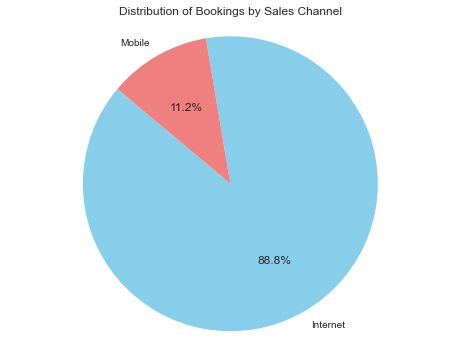

In [14]:
# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sales_channel_counts, labels=sales_channel_counts.index, autopct="%1.1f%%", startangle=140, colors=['skyblue', 'lightcoral'])
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular.

# Add a title
plt.title("Distribution of Bookings by Sales Channel")

# Display the pie chart
plt.show()

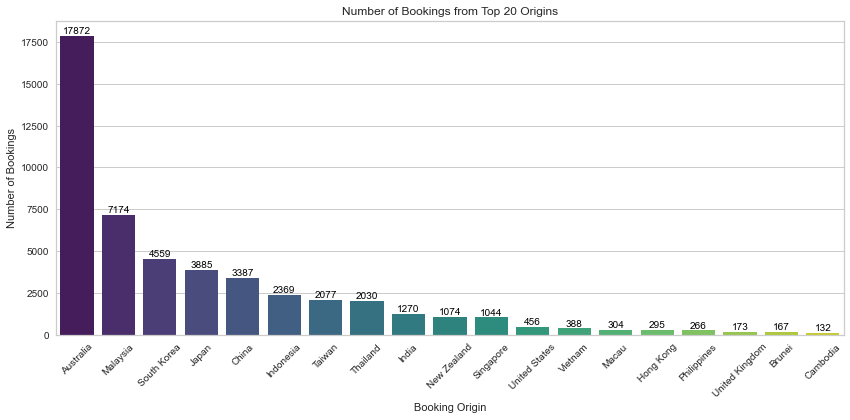

In [15]:
# Count the number of bookings for each booking origin
booking_origin_counts = df["booking_origin"].value_counts()

# Select the top 20 booking origins
top_20_booking_origins = booking_origin_counts[:19]

# Create a bar plot for the top 20 booking origins
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_20_booking_origins.index, y=top_20_booking_origins.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Booking Origin")
plt.ylabel("Number of Bookings")
plt.title("Number of Bookings from Top 20 Origins")

# Add count labels on top of each bar
for index, value in enumerate(top_20_booking_origins):
    ax.text(index, value + 19, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Display the bar plot
plt.tight_layout()
plt.show()

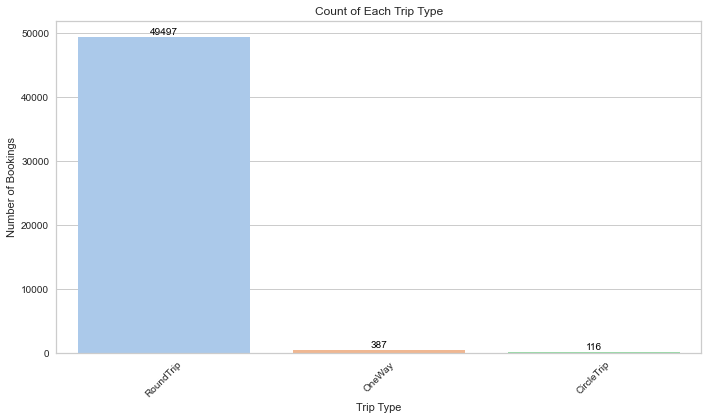

In [16]:
# Count the number of each trip type
trip_type_counts = df["trip_type"].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=trip_type_counts.index, y=trip_type_counts.values, palette="pastel")
plt.xlabel("Trip Type")
plt.ylabel("Number of Bookings")
plt.title("Count of Each Trip Type")

# Add count labels on top of each bar
for index, value in enumerate(trip_type_counts):
    ax.text(index, value + 20, str(value), ha='center', va='bottom', fontsize=10, color='black')

# Display the bar plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

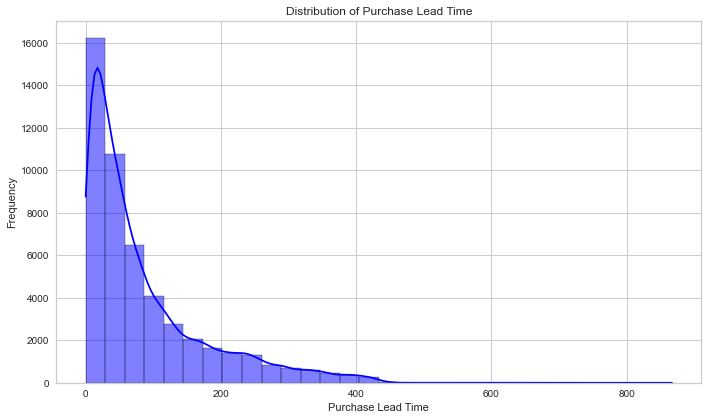

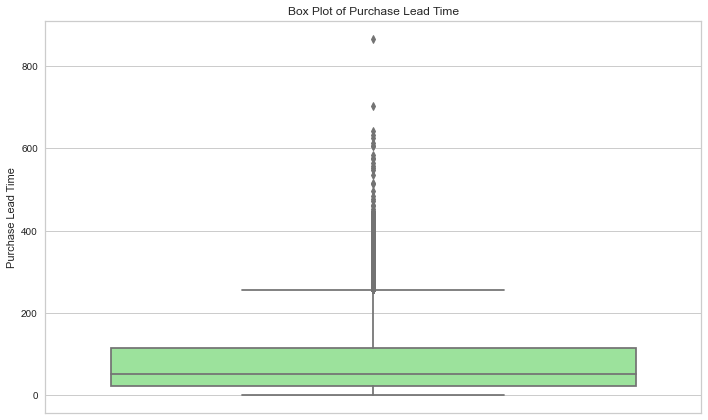

In [17]:
# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="purchase_lead", bins=30, kde=True, color='blue')
plt.xlabel("Purchase Lead Time")
plt.ylabel("Frequency")
plt.title("Distribution of Purchase Lead Time")

# Display the histogram
plt.tight_layout()
plt.show()

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="purchase_lead", color='lightgreen')
plt.ylabel("Purchase Lead Time")
plt.title("Box Plot of Purchase Lead Time")

# Display the box plot
plt.tight_layout()
plt.show()

In [18]:
(df.purchase_lead >600).value_counts()

False    49992
True         8
Name: purchase_lead, dtype: int64

In [19]:
df['length_of_stay'].unique()

array([ 19,  20,  22,  31,  48,  33,  30,  25,  43,  24,  17,  34,  18,
        37,  29, 155,  88,  27,  21,  28,  47,  35,  82,  26,  90,  23,
        84,  61,  40,  96,  69,  89,  58,  56, 110, 165, 111,  38, 207,
        91,   1, 274,  44,  57, 106,  68,  87,  51, 196,  77,  41, 278,
       108, 180,  72,  32,  62,  45,  50,  59, 125, 124,  46,  55,  60,
        36,  65, 208, 204,  83,  42,  85,  64,  86,  54, 238, 275,  39,
        95,  70,  93,  49, 107, 121, 203, 188,  78, 209, 126,  80, 200,
       255,  63,  92, 118,  79, 181,  76,  94, 305, 149, 177, 183, 162,
        71, 109,  52, 140,  66, 184, 152,  53, 291, 329,  75, 130, 142,
       175,  73, 304, 186, 116, 101, 223, 415, 312, 143,  81, 144, 134,
       135, 117, 120, 138, 153,  74, 261, 103, 104, 112, 157, 266,  98,
       318,  67, 273, 105, 148, 102, 119, 122, 603, 465, 409, 128, 233,
        99, 113, 147, 127,  97, 170, 156, 160, 182, 115, 158,   0, 357,
       173, 228, 205, 178, 123, 352, 141, 139, 129, 301, 176, 33

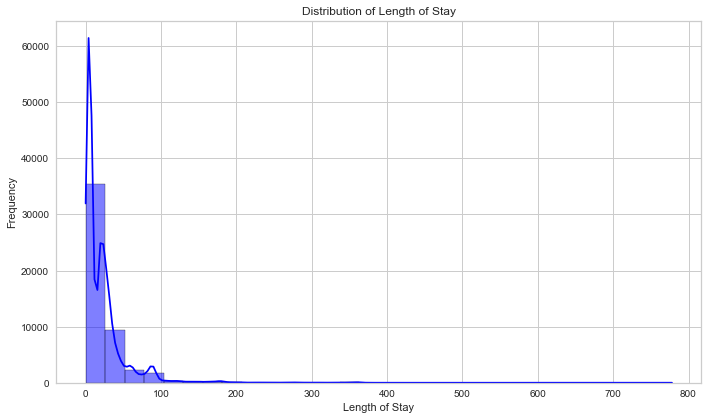

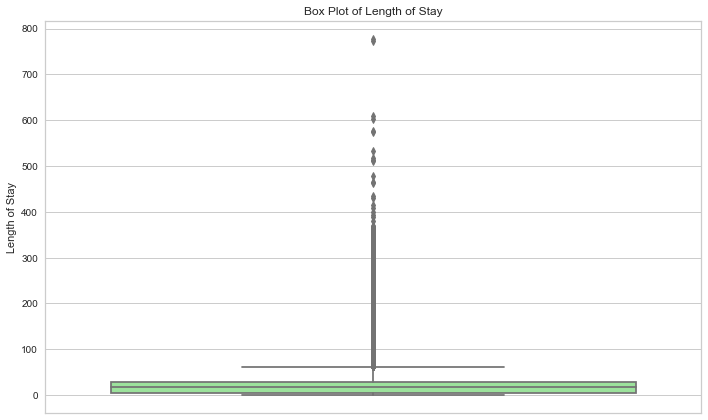

In [20]:
# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="length_of_stay", bins=30, kde=True, color='blue')
plt.xlabel("Length of Stay")
plt.ylabel("Frequency")
plt.title("Distribution of Length of Stay")

# Display the histogram
plt.tight_layout()
plt.show()

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="length_of_stay", color='lightgreen')
plt.ylabel("Length of Stay")
plt.title("Box Plot of Length of Stay")

# Display the box plot
plt.tight_layout()
plt.show()

In [21]:
# Number of flights on each days
df.flight_day.value_counts()

1    8102
3    7674
2    7673
4    7424
5    6761
7    6554
6    5812
Name: flight_day, dtype: int64

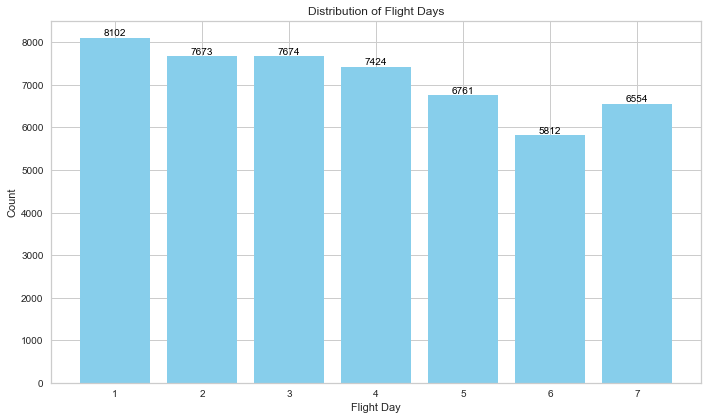

In [22]:
flight_day_counts = df.flight_day.value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(flight_day_counts.index, flight_day_counts.values, color='skyblue')
plt.xlabel("Flight Day")
plt.ylabel("Count")
plt.title("Distribution of Flight Days")

# Add count labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom', fontsize=10, color='black')

# Display the bar plot
plt.xticks(flight_day_counts.index)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of bookings')

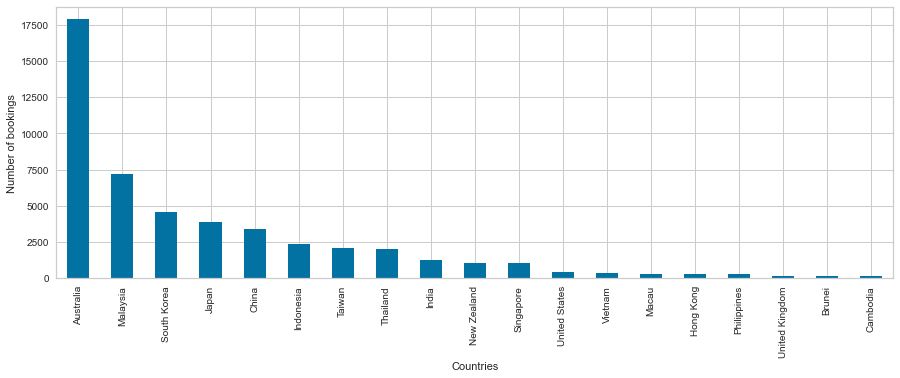

In [23]:
# Origin of the countries with most booking

plt.figure(figsize=(15,5))
ax = df.booking_origin.value_counts()[:19].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of bookings")

Text(0, 0.5, 'Number of complete bookings')

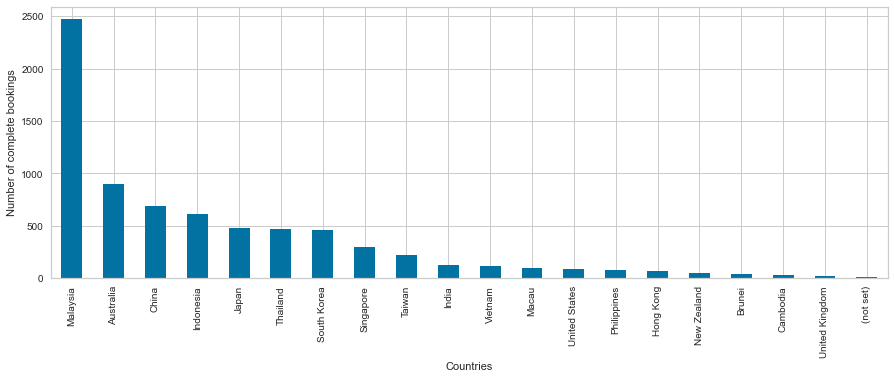

In [24]:
# Origin of the countries with most booking completed

plt.figure(figsize=(15,5))
ax = df[df.booking_complete ==1].booking_origin.value_counts()[:20].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of complete bookings")

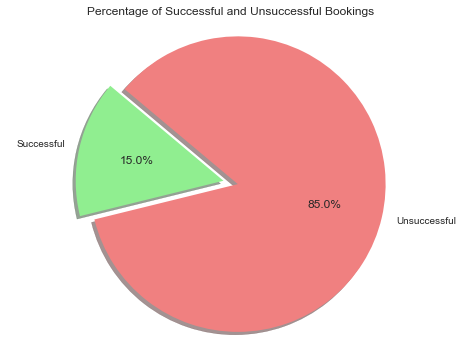

In [25]:
# Count the number of successful and unsuccessful bookings
booking_complete_counts = df["booking_complete"].value_counts()

# Calculate the percentages
total_bookings = booking_complete_counts.sum()
successful_percentage = (booking_complete_counts[1] / total_bookings) * 100
unsuccessful_percentage = (booking_complete_counts[0] / total_bookings) * 100

# Create a pie chart
plt.figure(figsize=(8, 6))
labels = ['Successful', 'Unsuccessful']
sizes = [successful_percentage, unsuccessful_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # Emphasize the successful slice
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140, explode=explode, shadow=True)
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular.

# Add a title
plt.title("Percentage of Successful and Unsuccessful Bookings")

# Display the pie chart
plt.show()

In [26]:
(df.purchase_lead >600).value_counts()

False    49992
True         8
Name: purchase_lead, dtype: int64

In [27]:
df[df.purchase_lead > 600]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
835,3,Internet,RoundTrip,641,46,6,7,AKLKUL,Malaysia,1,0,1,8.83,1
6148,1,Internet,RoundTrip,614,19,11,3,COKMEL,Australia,0,0,0,8.83,0
24119,1,Internet,RoundTrip,704,23,8,2,PNHSYD,Australia,0,0,0,8.58,0
38356,2,Internet,RoundTrip,633,5,10,6,HKTOOL,Australia,0,0,1,8.83,0
39417,1,Mobile,RoundTrip,625,5,15,5,ICNRGN,Myanmar (Burma),0,0,0,6.62,0
42916,1,Mobile,RoundTrip,605,6,18,4,BLRMEL,India,0,0,0,8.83,0
46716,2,Internet,RoundTrip,606,6,6,5,HKTTPE,United States,0,0,1,4.67,0
48259,3,Internet,RoundTrip,867,6,7,1,KIXMLE,Japan,0,0,1,7.00,1


In [28]:
#filtering the data to have only purchase lead days less than 600 days
df = df[df.purchase_lead <600 ]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49992 non-null  int64  
 1   sales_channel          49992 non-null  object 
 2   trip_type              49992 non-null  object 
 3   purchase_lead          49992 non-null  int64  
 4   length_of_stay         49992 non-null  int64  
 5   flight_hour            49992 non-null  int64  
 6   flight_day             49992 non-null  int64  
 7   route                  49992 non-null  object 
 8   booking_origin         49992 non-null  object 
 9   wants_extra_baggage    49992 non-null  int64  
 10  wants_preferred_seat   49992 non-null  int64  
 11  wants_in_flight_meals  49992 non-null  int64  
 12  flight_duration        49992 non-null  float64
 13  booking_complete       49992 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.7+ 

In [30]:
(df.length_of_stay> 500).value_counts()

False    49982
True        10
Name: length_of_stay, dtype: int64

In [31]:
df[df.length_of_stay > 500]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
1583,2,Internet,RoundTrip,32,603,0,4,AKLKUL,Malaysia,0,0,0,8.83,0
10294,1,Internet,RoundTrip,10,610,2,1,DMKSYD,Australia,1,1,0,8.58,0
10821,1,Internet,RoundTrip,102,778,8,3,DPSMEL,Australia,0,0,0,8.83,1
13214,1,Internet,RoundTrip,20,532,11,4,HYDPER,India,1,0,1,5.62,0
13439,1,Mobile,RoundTrip,18,513,10,6,HYDSYD,India,1,1,1,8.58,0
14828,1,Internet,RoundTrip,112,510,23,4,IKAMEL,Australia,1,1,1,8.83,0
21582,1,Internet,RoundTrip,9,573,11,4,OOLPNH,Australia,1,1,1,8.83,0
22081,2,Internet,RoundTrip,11,773,16,6,OOLTPE,Taiwan,1,0,1,8.83,0
23179,1,Internet,RoundTrip,65,517,14,2,PERPNH,Australia,1,1,1,5.62,0
24154,1,Internet,RoundTrip,367,577,2,1,PNHSYD,Australia,0,0,1,8.58,0


In [32]:
#filtering the data to have only length of stay days less than 500 days
df = df[df.purchase_lead <500 ]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49982 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49982 non-null  int64  
 1   sales_channel          49982 non-null  object 
 2   trip_type              49982 non-null  object 
 3   purchase_lead          49982 non-null  int64  
 4   length_of_stay         49982 non-null  int64  
 5   flight_hour            49982 non-null  int64  
 6   flight_day             49982 non-null  int64  
 7   route                  49982 non-null  object 
 8   booking_origin         49982 non-null  object 
 9   wants_extra_baggage    49982 non-null  int64  
 10  wants_preferred_seat   49982 non-null  int64  
 11  wants_in_flight_meals  49982 non-null  int64  
 12  flight_duration        49982 non-null  float64
 13  booking_complete       49982 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.7+ 

In [34]:
# Drop the 'route' column
df = df.drop(columns=['route','booking_origin'])

# Convert categorical variables using one-hot encoding
categorical_columns = ['sales_channel', 'trip_type']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [35]:
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
0,2,262,19,7,6,1,0,0,5.52,0,0,0,1
1,1,112,20,3,6,0,0,0,5.52,0,0,0,1
2,2,243,22,17,3,1,1,0,5.52,0,0,0,1
3,1,96,31,4,6,0,0,1,5.52,0,0,0,1
4,2,68,22,15,3,1,0,1,5.52,0,0,0,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49982 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49982 non-null  int64  
 1   purchase_lead          49982 non-null  int64  
 2   length_of_stay         49982 non-null  int64  
 3   flight_hour            49982 non-null  int64  
 4   flight_day             49982 non-null  int64  
 5   wants_extra_baggage    49982 non-null  int64  
 6   wants_preferred_seat   49982 non-null  int64  
 7   wants_in_flight_meals  49982 non-null  int64  
 8   flight_duration        49982 non-null  float64
 9   booking_complete       49982 non-null  int64  
 10  sales_channel_Mobile   49982 non-null  uint8  
 11  trip_type_OneWay       49982 non-null  uint8  
 12  trip_type_RoundTrip    49982 non-null  uint8  
dtypes: float64(1), int64(9), uint8(3)
memory usage: 4.3 MB


In [37]:
# Convert uint8 columns to int or float
columns_to_convert = ['sales_channel_Mobile', 'trip_type_OneWay', 'trip_type_RoundTrip']
df[columns_to_convert] = df[columns_to_convert].astype(int)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49982 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49982 non-null  int64  
 1   purchase_lead          49982 non-null  int64  
 2   length_of_stay         49982 non-null  int64  
 3   flight_hour            49982 non-null  int64  
 4   flight_day             49982 non-null  int64  
 5   wants_extra_baggage    49982 non-null  int64  
 6   wants_preferred_seat   49982 non-null  int64  
 7   wants_in_flight_meals  49982 non-null  int64  
 8   flight_duration        49982 non-null  float64
 9   booking_complete       49982 non-null  int64  
 10  sales_channel_Mobile   49982 non-null  int64  
 11  trip_type_OneWay       49982 non-null  int64  
 12  trip_type_RoundTrip    49982 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 5.3 MB


In [39]:
#store the label for supervised learning
label = df['booking_complete']

In [40]:
df_final = df.drop('booking_complete', axis=1)

In [41]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49982 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49982 non-null  int64  
 1   purchase_lead          49982 non-null  int64  
 2   length_of_stay         49982 non-null  int64  
 3   flight_hour            49982 non-null  int64  
 4   flight_day             49982 non-null  int64  
 5   wants_extra_baggage    49982 non-null  int64  
 6   wants_preferred_seat   49982 non-null  int64  
 7   wants_in_flight_meals  49982 non-null  int64  
 8   flight_duration        49982 non-null  float64
 9   sales_channel_Mobile   49982 non-null  int64  
 10  trip_type_OneWay       49982 non-null  int64  
 11  trip_type_RoundTrip    49982 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 5.0 MB


In [42]:
# Select columns to scale
columns_to_scale = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day',
                    'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
                    'flight_duration', 'sales_channel_Mobile', 'trip_type_OneWay', 'trip_type_RoundTrip']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
df_final[columns_to_scale] = scaler.fit_transform(df_final[columns_to_scale])

In [43]:
df_final.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip
0,0.400769,1.971093,-0.119401,-0.381588,1.096876,0.703587,-0.650054,-0.863557,-1.174049,-0.355786,-0.088336,0.100826
1,-0.579424,0.302987,-0.089895,-1.120618,1.096876,-1.421288,-0.650054,-0.863557,-1.174049,-0.355786,-0.088336,0.100826
2,0.400769,1.759799,-0.030885,1.465988,-0.408618,0.703587,1.538334,-0.863557,-1.174049,-0.355786,-0.088336,0.100826
3,-0.579424,0.125056,0.234662,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.174049,-0.355786,-0.088336,0.100826
4,0.400769,-0.186323,-0.030885,1.096473,-0.408618,0.703587,-0.650054,1.158002,-1.174049,-0.355786,-0.088336,0.100826


In [44]:
df_final['label'] = label

In [45]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49982 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49982 non-null  float64
 1   purchase_lead          49982 non-null  float64
 2   length_of_stay         49982 non-null  float64
 3   flight_hour            49982 non-null  float64
 4   flight_day             49982 non-null  float64
 5   wants_extra_baggage    49982 non-null  float64
 6   wants_preferred_seat   49982 non-null  float64
 7   wants_in_flight_meals  49982 non-null  float64
 8   flight_duration        49982 non-null  float64
 9   sales_channel_Mobile   49982 non-null  float64
 10  trip_type_OneWay       49982 non-null  float64
 11  trip_type_RoundTrip    49982 non-null  float64
 12  label                  49982 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 5.3 MB


In [46]:
df_final.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,label
0,0.400769,1.971093,-0.119401,-0.381588,1.096876,0.703587,-0.650054,-0.863557,-1.174049,-0.355786,-0.088336,0.100826,0
1,-0.579424,0.302987,-0.089895,-1.120618,1.096876,-1.421288,-0.650054,-0.863557,-1.174049,-0.355786,-0.088336,0.100826,0
2,0.400769,1.759799,-0.030885,1.465988,-0.408618,0.703587,1.538334,-0.863557,-1.174049,-0.355786,-0.088336,0.100826,0
3,-0.579424,0.125056,0.234662,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.174049,-0.355786,-0.088336,0.100826,0
4,0.400769,-0.186323,-0.030885,1.096473,-0.408618,0.703587,-0.650054,1.158002,-1.174049,-0.355786,-0.088336,0.100826,0


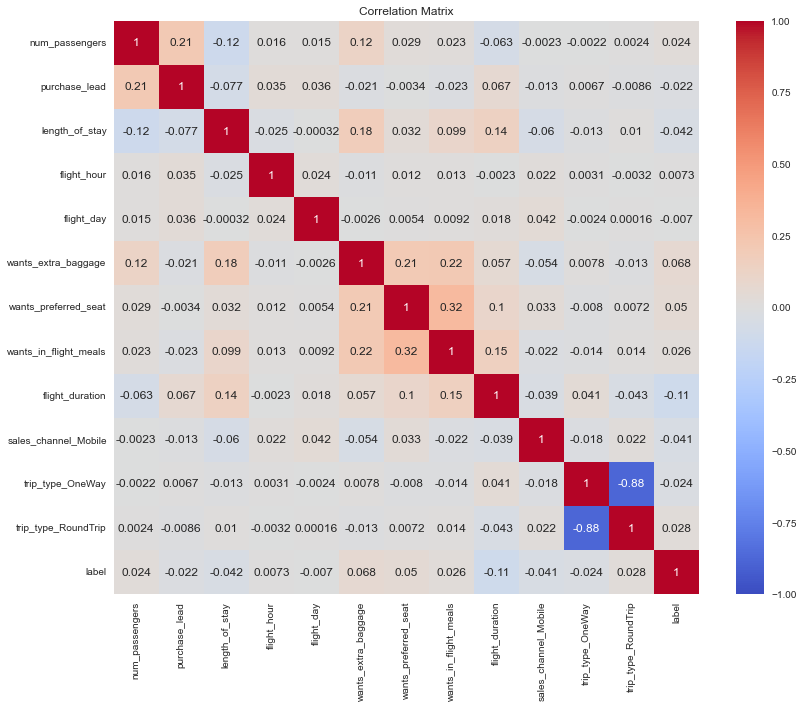

In [47]:
# Create a correlation matrix
correlation_matrix = df_final.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with nicer colors and correlation scores
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Add a title
plt.title("Correlation Matrix")

# Show the plot
plt.tight_layout()
plt.show()


In [48]:
# Select features and target
X = df_final.iloc[:,:-1]
y = df_final['label']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
"""
    Create functions to fit and predict the values of whether customer would complete the booking.
    Also functions with metrics to evaluate the model prediction.

"""

def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
    return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

In [50]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

In [51]:
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

#f1 score for training data
f1 = round(f1_score(y_train, y_pred_train),2) 

#accuracy score for training data
acc = round(accuracy_score(y_train, y_pred_train),2) 

#precision score for training data
pre = round(precision_score(y_train, y_pred_train),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.94, 1.0 and 0.74 respectively


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9379017131424284

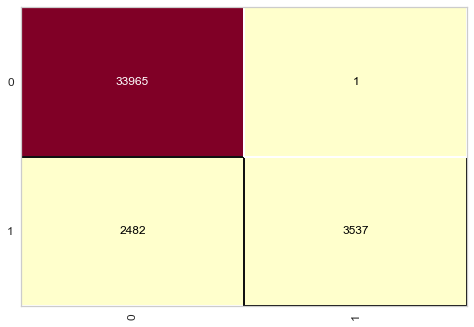

In [52]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_train, y_train)

In [53]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.85, 0.45 and 0.07 respectively


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.8531559467840352

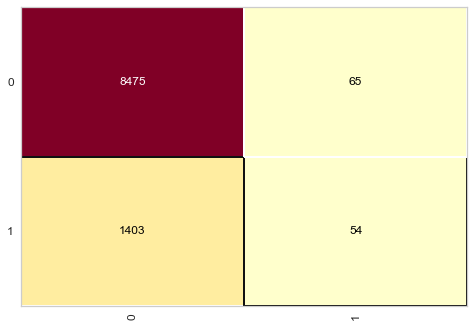

In [54]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

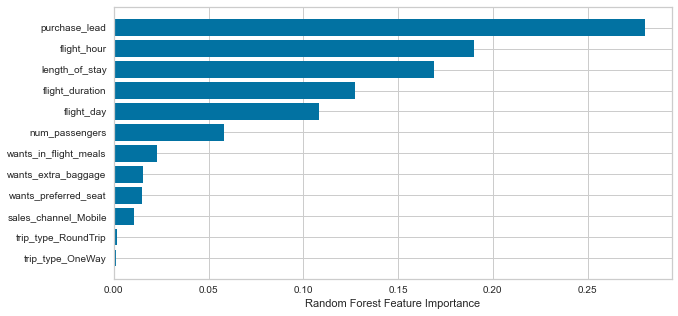

In [55]:
plt.figure(figsize=(10,5))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(df_final.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [56]:
df_final.label.value_counts()

0    42506
1     7476
Name: label, dtype: int64

In [58]:
#create a dataframe having all labels 0 with 8000 samples
scaled_df_0 = df_final[df_final.label ==0].sample(n=8000)

In [59]:
#concatenate the two dataframee, one havng all labels 0 and other having all labels as 1
scaled_df_new = pd.concat([df_final[df_final.label==1], scaled_df_0], ignore_index=True)

In [60]:
#shuffle the dataframe rows
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)

In [62]:
scaled_df_new

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,label
0,-0.579424,0.158418,0.382189,0.911715,0.093214,0.703587,1.538334,1.158002,1.037314,-0.355786,-0.088336,0.100826,0
1,-0.579424,-0.197444,-0.502969,-1.305376,0.595045,0.703587,-0.650054,-0.863557,1.037314,-0.355786,-0.088336,0.100826,0
2,3.341348,0.147298,-0.532474,-0.751103,-1.412280,0.703587,-0.650054,1.158002,-1.300985,-0.355786,-0.088336,0.100826,1
3,0.400769,0.058332,-0.060390,1.096473,-0.910449,-1.421288,-0.650054,-0.863557,1.037314,-0.355786,-0.088336,0.100826,0
4,-0.579424,-0.330893,-0.532474,0.726958,1.096876,0.703587,-0.650054,-0.863557,-0.439155,-0.355786,-0.088336,0.100826,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,-0.579424,-0.519945,0.470704,0.357443,1.096876,0.703587,1.538334,1.158002,1.037314,-0.355786,-0.088336,0.100826,0
15472,0.400769,-0.430979,-0.561979,-0.566346,-0.408618,0.703587,1.538334,1.158002,-0.439155,-0.355786,-0.088336,0.100826,1
15473,0.400769,-0.175203,-0.502969,-0.566346,-0.910449,0.703587,1.538334,-0.863557,1.037314,-0.355786,-0.088336,0.100826,1
15474,0.400769,-0.453220,-0.502969,-1.120618,-0.910449,-1.421288,1.538334,1.158002,1.037314,-0.355786,-0.088336,0.100826,1


In [63]:
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [64]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [65]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

recall = round(recall_score(y_test, y_pred_test),2)

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

print(f"Accuracy, precision, recall and f1-score for training data are {acc}, {pre}, {recall}, {specificity} and {f1}")

Accuracy, precision, recall and f1-score for training data are 0.62, 0.61, 0.58, 0.65 and 0.6


0.6172480620155039

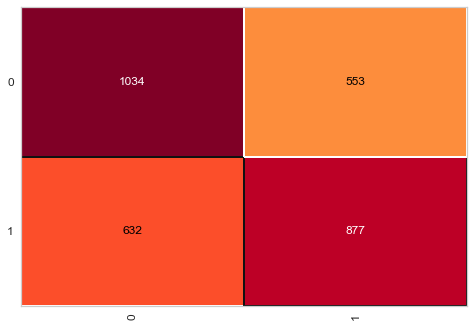

In [66]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_test, y_test)

Text(0.5, 0, 'Random Forest Feature Importance')

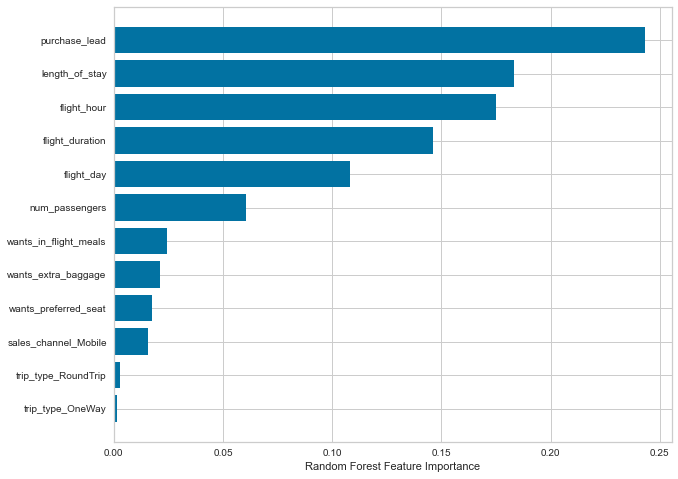

In [68]:
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(df_final.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")